In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

In [2]:
from invcov import *

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


In [3]:
import numpy as np
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
from cupyx.profiler import benchmark

In [4]:
mat1 = cp.random.rand(2, 3, 4)
mat2 = cp.random.rand(2, 4, 3)

In [5]:
mat3 = mat1 @ mat2

In [6]:
print(mat3.shape)

(2, 3, 3)


In [7]:
print(mat1.shape)
print(mat1.T.shape)
print(cp.transpose(mat1, [0, 2, 1]).shape)

(2, 3, 4)
(4, 3, 2)
(2, 4, 3)


In [8]:
vec1 = cp.random.rand(10)
print(vec1)
vec2 = cp.random.rand(10)
print(vec2)
print(vec1*vec2)
print(vec1 @ vec2)
print(cp.sum(vec1 * vec2, axis=0))

[0.92767317 0.73202407 0.82710016 0.64495396 0.36294091 0.20931749
 0.36225362 0.83547294 0.58112137 0.24870753]
[0.95979275 0.28727099 0.18593416 0.34242711 0.8457359  0.97078467
 0.54570585 0.91315887 0.25947753 0.68218367]
[0.89037398 0.21028928 0.15378617 0.22084972 0.30695216 0.20320222
 0.19768392 0.76291953 0.15078794 0.16966422]
3.2665091327534985
3.2665091327534985


In [9]:
#note this might be a really good time to consider making a covariance class 
#this way, this function could in theory inherit all of the mattrices like N, Sig, Del,
#and also N_inv, Del_prime, Sig_prime

def sparse_cov_times_vec(N, Del, Sig, N_inv, Del_prime, Sig_prime, vec, isinv, xp):
    if vec.ndim == 2:
        vec = vec.reshape(vec.shape[0], vec.shape[1], 1)
        N_inv = N_inv.reshape(vec.shape[0], vec.shape[1], 1)
    else:
        pass
    if isinv:
        del_tmp = xp.transpose(Del_prime, [0, 2, 1]) @ vec
        sig_tmp = xp.sum(xp.transpose(Sig_prime, [0, 2, 1]) @ vec, axis=0)
        out = N_inv * vec - Del_prime @ del_tmp - Sig_prime @ sig_tmp
    else:
        del_tmp = xp.transpose(Del, [0, 2, 1]) @ vec
        sig_tmp = xp.sum(xp.transpose(Sig, [0, 2, 1]) @ vec, axis=0)
        out = N * vec + Del_prime @ del_tmp + Sig_prime @ sig_tmp        
    return out

In [29]:
#the main parametes describing our problem.
n_bl = 2000
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 4))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
if xp == np:
    sim_noise_mat = (xp.random.rand(n_bl)**2).astype('float64')   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(n_bl, n_eig).astype('float64')
    sim_src_mat = xp.random.rand(n_bl, n_src).astype('float64')
    sim_data_vec = xp.random.rand(n_bl).astype('float64')
    print(type(sim_noise_mat))
    print(type(sim_diff_mat))
    print(type(sim_src_mat))
    print(type(sim_data_vec))
elif xp == cp:
    sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
    sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')
    sim_data_vec = xp.random.rand(n_bl, dtype = 'float64')
    print(type(sim_noise_mat))
    print(type(sim_diff_mat))
    print(type(sim_src_mat))
    print(type(sim_data_vec))

The edges of the redundant blocks have indices[   0  286  946 1195 1940 2000]
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>


In [30]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #return inverse set to False for sims later on
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)
zp_sim_data_vec, largest_block, n_blocks = zeroPad(sim_data_vec, edges, return_inv=False)

#Need to reshape to give an extra dimension of n_blocks to be compatible with inv cov routine
sim_noise_mat_2d = zp_sim_noise_mat_inv.reshape(n_blocks, largest_block)   #Again, its worth noting the values of the noise mat are really 1/noise_vals here
sim_diff_mat_3d = zp_sim_diff_mat.reshape(n_blocks, largest_block, n_eig)
sim_src_mat_3d = zp_sim_src_mat.reshape(n_blocks, largest_block, n_src)
sim_data_vec_2d = zp_sim_data_vec.reshape(n_blocks, largest_block)

In [31]:
#find inverse components, noting the result will still be a set of zeropadded matrices
#Note we feed the inverse noise components to the inverse cov routine as can be seen by the N_is_inv=True
logdet, N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, edges=edges, xp = xp , ret_det = True, N_is_inv=True)
print(Del_p.shape)

(5, 745, 3)


In [32]:
out = sparse_cov_times_vec(sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, N_inv, Del_p, Sig_p, sim_data_vec_2d, isinv=True, xp = cp)
out_reshape = out.reshape(n_blocks*largest_block)

In [33]:
print(benchmark(sparse_cov_times_vec, (sim_noise_mat_2d, sim_diff_mat_3d, sim_src_mat_3d, N_inv, Del_p, Sig_p, sim_data_vec_2d, True, cp), n_repeat=100))

sparse_cov_times_vec:    CPU:   800.702 us   +/- 287.925 (min:   543.687 / max:  1968.818) us     GPU-0:  1188.321 us   +/- 1637.401 (min:   235.520 / max:  7873.536) us


In [34]:
N_inv = N_inv.reshape(n_blocks * largest_block)
Del_p = Del_p.reshape(n_blocks * largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks * largest_block, n_src)

In [35]:
#convert sparse things to dense things to visualize what we're really working with
Del_p_dense = sparden_convert(Del_p, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=True)

In [36]:
dense_cov_inv = cp.diag(N_inv) - Del_p_dense @ Del_p_dense.T - Sig_p @ Sig_p.T
print(dense_cov_inv.shape)
dense_cov_inv_times_vec = dense_cov_inv @ zp_sim_data_vec
print(dense_cov_inv_times_vec.shape)
print(out_reshape.shape)
print(np.allclose(dense_cov_inv_times_vec, out_reshape))

(3725, 3725)
(3725,)
(3725,)
True


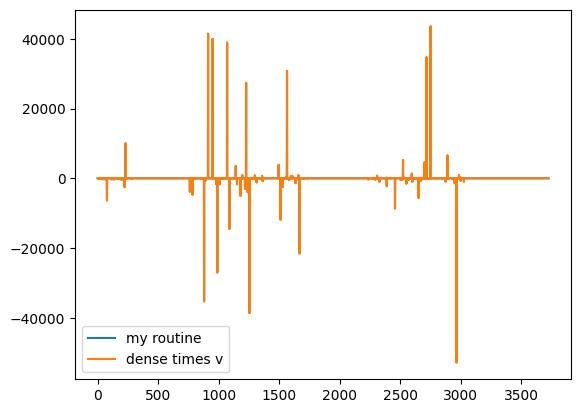

In [37]:
plt.plot(cp.asnumpy(out_reshape), label = "my routine")
plt.plot(cp.asnumpy(dense_cov_inv_times_vec), label = "dense times v")
plt.legend()